<a href="https://colab.research.google.com/github/PacktPublishing/Hands-On-Computer-Vision-with-PyTorch/blob/master/Chapter15/Handwriting_transcription.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!wget https://www.dropbox.com/s/l2ul3upj7dkv4ou/synthetic-data.zip
#!unzip -qq synthetic-data.zip

In [2]:
#!pip install torch_snippets torch_summary editdistance

In [2]:
from torch_snippets import *
from torchsummary import summary
import editdistance


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
dfs1 = pd.read_excel('Date Strings Part I/Part I.xlsx')
dfs2 = pd.read_excel('Date Strings Part II/Part II.xlsx')
dfs3 = pd.read_excel('Date Strings Part III/Part III.xlsx')
labels_train = {}
labels_test = {}
train_items = []
test_items = []

In [5]:
for i in range(len(dfs1)):
    if not pd.isnull(dfs1.iloc[i,:].Image_Left):
        if (str(dfs1.iloc[i,:].Date)[1] == '9' and int(str(dfs1.iloc[i,:].Date)[2]) < 2) or (str(dfs1.iloc[i,:].Date)[1] == '8'):
            labels_train[dfs1.iloc[i,:].Image_Left] = str(dfs1.iloc[i,:].Date)
            train_items.append('Date Strings Part I/Part I/' + dfs1.iloc[i,:].Image_Left + '.jpg')
        else:
            labels_test[dfs1.iloc[i,:].Image_Left] = str(dfs1.iloc[i,:].Date)
            test_items.append('Date Strings Part I/Part I/' + dfs1.iloc[i,:].Image_Left + '.jpg')
    if not pd.isnull(dfs1.iloc[i,:].Image_Right):
        if (str(dfs1.iloc[i,:].Date)[1] == '9' and int(str(dfs1.iloc[i,:].Date)[2]) < 2) or (str(dfs1.iloc[i,:].Date)[1] == '8'):
            labels_train[dfs1.iloc[i,:].Image_Right] = str(dfs1.iloc[i,:].Date)
            train_items.append('Date Strings Part I/Part I/' + dfs1.iloc[i,:].Image_Right + '.jpg')
        else:
            labels_test[dfs1.iloc[i,:].Image_Right] = str(dfs1.iloc[i,:].Date)
            test_items.append('Date Strings Part I/Part I/' + dfs1.iloc[i,:].Image_Right + '.jpg')

In [6]:
for i in range(len(dfs2)):
    if not pd.isnull(dfs2.iloc[i,:].Image_Left):
        labels_train[dfs2.iloc[i,:].Image_Left] = str(dfs2.iloc[i,:].Date)
        train_items.append('Date Strings Part II/Part II/' + dfs2.iloc[i,:].Image_Left + '.jpg')
    if not pd.isnull(dfs2.iloc[i,:].Image_Right):
        labels_train[dfs2.iloc[i,:].Image_Right] = str(dfs2.iloc[i,:].Date)
        train_items.append('Date Strings Part II/Part II/' + dfs2.iloc[i,:].Image_Right + '.jpg')

In [7]:
for i in range(len(dfs3)):
    labels_test[dfs3.iloc[i,:].Image_name] = str(dfs3.iloc[i,:].Date)
    test_items.append('Date Strings Part III/Part III/' + dfs3.iloc[i,:].Image_name + '.jpg')

In [8]:
len(labels_train), len(labels_test)

(7924, 2076)

In [9]:
labels_total = {**labels_train, **labels_test}
len(labels_total)

10000

In [10]:
#fname2label = lambda fname: stem(fname).split('@')[0]
def fname2label(fname):
    if fname[18:21] == 'III':
        return labels_total[fname[31:-4]]
    if fname[18:21] == 'II/':
        return labels_total[fname[29:-4]]
    else:
        return labels_total[fname[27:-4]]
#images = Glob('Date Strings Part I/Part I/*.png') + Glob('Date Strings Part II/Part II/*.png') + Glob('Date Strings Part III/Part III/*.png')

In [11]:
vocab = '0123456789'
B, T, V = 64, 16, len(vocab)
H, W = 32, 128

In [12]:
class OCRDataset(Dataset):
    def __init__(self, items, vocab=vocab, timesteps=T):
        super().__init__()
        self.items = items
        self.charList = {ix+1:ch for ix,ch in enumerate(vocab)}
        self.charList.update({0: '`'})
        self.invCharList = {v:k for k,v in self.charList.items()}
        self.ts = timesteps
    def __len__(self):
        return len(self.items)
    def sample(self):
        return self[randint(len(self))]
    def __getitem__(self, ix):
        item = str(self.items[ix])
        image = cv2.imread(item, 0)
        label = fname2label(item)
        return image, label
    def collate_fn(self, batch):
        images, labels, label_lengths, label_vectors, input_lengths = [], [], [], [], []
        for image, label in batch:
            images.append(torch.Tensor(self.preprocess(image))[None,None])
            label_lengths.append(len(label))
            labels.append(label)
            label_vectors.append(self.str2vec(label))
            input_lengths.append(self.ts)
        images = torch.cat(images).float().to(device)
        label_lengths = torch.Tensor(label_lengths).long().to(device)
        label_vectors = torch.Tensor(label_vectors).long().to(device)
        input_lengths = torch.Tensor(input_lengths).long().to(device)
        return images, label_vectors, label_lengths, input_lengths, labels
    def str2vec(self, string, pad=True):
        string = ''.join([s for s in string if s in self.invCharList])
        val = list(map(lambda x: self.invCharList[x], string)) 
        if pad:
            while len(val) < self.ts:
                val.append(0)
        return val
    def preprocess(self, img, shape=(32,128)):
        target = np.ones(shape)*255
        try:
            H, W = shape
            h, w = img.shape
            fx = H/h
            fy = W/w
            f = min(fx, fy)
            _h = int(h*f)
            _w = int(w*f)
            _img = cv2.resize(img, (_w,_h))
            target[:_h,:_w] = _img
        except:
            ...
        return (255-target)/255
    def decoder_chars(self, pred):
        decoded = ""
        last = ""
        pred = pred.cpu().detach().numpy()
        for i in range(len(pred)):
            k = np.argmax(pred[i])
            if k > 0 and self.charList[k] != last:
                last = self.charList[k]
                decoded = decoded + last
            elif k > 0 and self.charList[k] == last:
                continue
            else:
                last = ""
        return decoded.replace(" "," ")
    def wer(self, preds, labels):
        c = 0
        for p, l in zip(preds, labels):
            c += p.lower().strip() != l.lower().strip()
        return round(c/len(preds), 4)
    def cer(self, preds, labels):
        c, d = [], []
        for p, l in zip(preds, labels):
            c.append(editdistance.eval(p, l) / len(l))
        return round(np.mean(c), 4)
    def evaluate(self, model, ims, labels, lower=False):
        model.eval()
        preds = model(ims).permute(1,0,2) # B, T, V+1
        preds = [self.decoder_chars(pred) for pred in preds]
        return {'digit-error-rate': self.cer(preds, labels),
                'whole-number-error-rate': self.wer(preds, labels),
                'digit-accuracy' : 1 - self.cer(preds, labels),
                'whole-number-accuracy' : 1 - self.wer(preds, labels)}


In [13]:
from sklearn.model_selection import train_test_split
#trn_items, val_items = train_test_split(Glob('synthetic-data'), test_size=0.2, random_state=22)

trn_ds = OCRDataset(train_items)
val_ds = OCRDataset(test_items)

trn_dl = DataLoader(trn_ds, batch_size=B, collate_fn=trn_ds.collate_fn, drop_last=True, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=B, collate_fn=val_ds.collate_fn, drop_last=True)

In [14]:
from torch_snippets import Reshape, Permute
class BasicBlock(nn.Module):
    def __init__(self, ni, no, ks=3, st=1, padding=1, pool=2, drop=0.2):
        super().__init__()
        self.ks = ks
        self.block = nn.Sequential(
            nn.Conv2d(ni, no, kernel_size=ks, stride=st, padding=padding),
            nn.BatchNorm2d(no, momentum=0.3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(pool),
            nn.Dropout2d(drop)
        )
    def forward(self, x):
        return self.block(x)

In [15]:
class Ocr(nn.Module):
    def __init__(self, vocab):
        super().__init__()
        self.model = nn.Sequential(
            BasicBlock( 1, 128),
            BasicBlock(128, 128),
            BasicBlock(128, 256, pool=(4,2)),
            Reshape(-1, 256, 32),
            Permute(2, 0, 1) # T, B, D
        )
        self.rnn = nn.Sequential(
            nn.LSTM(256, 256, num_layers=2, dropout=0.2, bidirectional=True),
        )
        self.classification = nn.Sequential(
            nn.Linear(512, vocab+1),
            nn.LogSoftmax(-1),
        )
    def forward(self, x):
        x = self.model(x)
        x, lstm_states = self.rnn(x)
        y = self.classification(x)
        return y

In [16]:
def ctc(log_probs, target, input_lengths, target_lengths, blank=0):
    loss = nn.CTCLoss(blank=blank, zero_infinity=True)
    ctc_loss = loss(log_probs, target, input_lengths, target_lengths)
    return ctc_loss

In [17]:
model = Ocr(len(vocab)).to(device)
#!pip install torch_summary
from torchsummary import summary
summary(model, torch.zeros((1,1,32,128)).to(device))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1, 256]              --
|    └─BasicBlock: 2-1                   [-1, 128, 16, 64]         --
|    |    └─Sequential: 3-1              [-1, 128, 16, 64]         1,536
|    └─BasicBlock: 2-2                   [-1, 128, 8, 32]          --
|    |    └─Sequential: 3-2              [-1, 128, 8, 32]          147,840
|    └─BasicBlock: 2-3                   [-1, 256, 2, 16]          --
|    |    └─Sequential: 3-3              [-1, 256, 2, 16]          295,680
|    └─Reshape: 2-4                      [-1, 256, 32]             --
|    └─Permute: 2-5                      [-1, 1, 256]              --
├─Sequential: 1-2                        [-1, 1, 512]              --
|    └─LSTM: 2-6                         [-1, 1, 512]              2,629,632
├─Sequential: 1-3                        [-1, 1, 11]               --
|    └─Linear: 2-7                       [-1, 1, 11]             

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1, 256]              --
|    └─BasicBlock: 2-1                   [-1, 128, 16, 64]         --
|    |    └─Sequential: 3-1              [-1, 128, 16, 64]         1,536
|    └─BasicBlock: 2-2                   [-1, 128, 8, 32]          --
|    |    └─Sequential: 3-2              [-1, 128, 8, 32]          147,840
|    └─BasicBlock: 2-3                   [-1, 256, 2, 16]          --
|    |    └─Sequential: 3-3              [-1, 256, 2, 16]          295,680
|    └─Reshape: 2-4                      [-1, 256, 32]             --
|    └─Permute: 2-5                      [-1, 1, 256]              --
├─Sequential: 1-2                        [-1, 1, 512]              --
|    └─LSTM: 2-6                         [-1, 1, 512]              2,629,632
├─Sequential: 1-3                        [-1, 1, 11]               --
|    └─Linear: 2-7                       [-1, 1, 11]             

In [18]:
def train_batch(data, model, optimizer, criterion):
    model.train()
    imgs, targets, label_lens, input_lens, labels = data
    optimizer.zero_grad()
    preds = model(imgs)
    loss = criterion(preds, targets, input_lens, label_lens)
    loss.backward()
    optimizer.step()
    results = trn_ds.evaluate(model, imgs.to(device), labels)
    return loss, results

In [19]:
@torch.no_grad()
def validate_batch(data, model):
    model.eval()
    imgs, targets, label_lens, input_lens, labels = data
    preds = model(imgs)
    loss = criterion(preds, targets, input_lens, label_lens)
    return loss, val_ds.evaluate(model, imgs.to(device), labels)

In [20]:
model = Ocr(len(vocab)).to(device)
criterion = ctc

optimizer = optim.AdamW(model.parameters(), lr=3e-3)

n_epochs = 20
log = Report(n_epochs)

In [21]:
for ep in range( n_epochs):
    # if ep in lr_schedule: optimizer = AdamW(ocr.parameters(), lr=lr_schedule[ep])
    N = len(trn_dl)
    for ix, data in enumerate(trn_dl):
        pos = ep + (ix+1)/N
        loss, results = train_batch(data, model, optimizer, criterion)
        # scheduler.step()
        ca, wa = results['digit-accuracy'], results['whole-number-accuracy']
        log.record(pos=pos, train_loss=loss, train_digit_acc=ca, train_whole_digit_acc=wa, end='\r')
    val_results = []
    N = len(val_dl)
    for ix, data in enumerate(val_dl):
        pos = ep + (ix+1)/N
        loss, results = validate_batch(data, model)
        ca, wa = results['digit-accuracy'], results['whole-number-accuracy']
        log.record(pos=pos, test_loss=loss, test_digit_acc=ca, test_whole_digit_acc=wa, end='\r')

    log.report_avgs(ep+1)
    print()
    for jx in range(5):
        img, label = val_ds.sample()
        _img = torch.Tensor(val_ds.preprocess(img)[None,None]).to(device)
        pred = model(_img)[:,0,:]
        pred = trn_ds.decoder_chars(pred)
        print(f'Pred: `{pred}` :: Truth: `{label}`')
    print()

EPOCH: 0.488	train_loss: 1.475	train_digit_acc: 0.496	train_whole_digit_acc: 0.000	(12.45s - 498.02s remaining)

KeyboardInterrupt: 

100%|██████████| 151/151 [00:00<00:00, 897.06it/s]


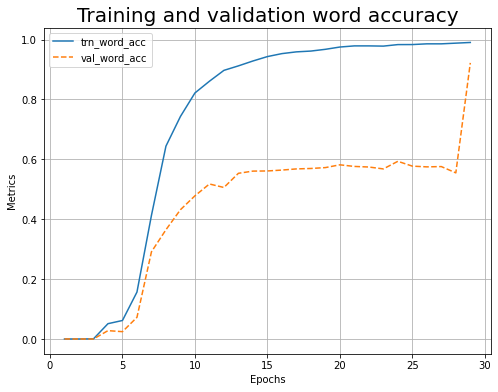

In [ ]:
log.plot_epochs(['trn_word_acc','val_word_acc'], title='Training and validation word accuracy')